# Parte 1: Preprocesamiento de Texto (NLP)
## Dataset: Mercado Libre's Best Sellers (Argentina) 09/23  
**Objetivo**: Preprocesamiento de texto y modelado predictivo de categorías, contiene 1,500 productos top de Mercado Libre Argentina, con:  
- Nombre del producto  
- Precio en ARS  
- Categoría  
- Cantidad vendida  
- Rating promedio  


[Ver dataset en Kaggle](https://www.kaggle.com/datasets/yannlecorre/most-sold-products-from-mercado-libre-argentina)  
**Github actualizado:** [Ver repositorio](https://github.com/GenelfJSP/Data_Science_III_Piana.git)


In [ ]:
# Instalar gensim primero
# 1. Ejecutar este bloque
!pip install gensim

## 1. Configuración Inicial
Importación de librerías y carga de datos

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import bigrams, FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import io
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
from textblob import TextBlob

# Descargas necesarias NLTK
nltk.download(['punkt', 'stopwords', 'omw-1.4', 'punkt_tab'])

# Carga de datos
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Saving ml-highlights_2023-09-07_00-12-12.csv to ml-highlights_2023-09-07_00-12-12 (1).csv


## 2. Análisis Exploratorio (EDA)
Estadísticas descriptivas y visualizaciones iniciales


Datos Básicos
Filas: 531 | Columnas: 9

Columnas disponibles: ['Unnamed: 0', 'id', 'sold_quantity', 'name', 'price', 'date_created', 'category_name', 'category_id', 'entity_type']


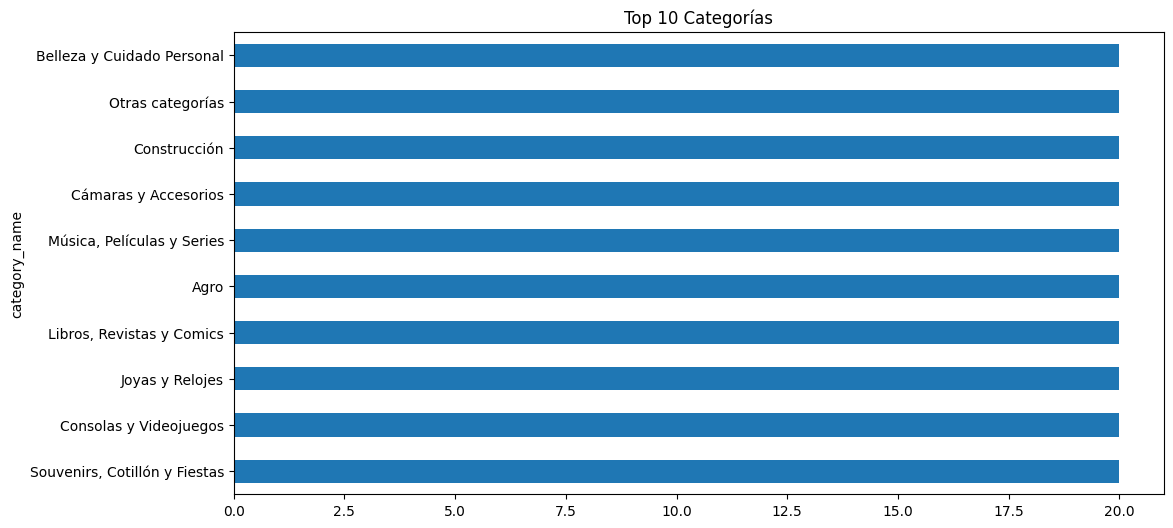

               price  sold_quantity
count     531.000000     531.000000
mean    19436.234934   25734.035782
std     40793.439641   54351.543358
min       199.000000       3.000000
25%      4029.650000    1406.000000
50%      9887.500000    5932.000000
75%     20285.000000   25642.500000
max    649999.000000  644060.000000


In [2]:
print("\nDatos Básicos")
print(f"Filas: {len(df)} | Columnas: {len(df.columns)}")
print("\nColumnas disponibles:", df.columns.tolist())

# Gráfico de distribución de categorías
plt.figure(figsize=(12,6))
df['category_name'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Categorías')
plt.show()

# Estadísticas numéricas
print(df[['price', 'sold_quantity']].describe())

## 3. Preprocesamiento de Texto
Limpieza, tokenización y normalización

In [3]:
def preprocesar_texto(texto, idioma='spanish'):
    # Tokenización
    tokens = word_tokenize(str(texto).lower()) if pd.notna(texto) else []

    # Filtrado
    tokens = [word for word in tokens if word.isalnum() and len(word) > 2]

    # Stopwords personalizadas
    stop_words = set(stopwords.words(idioma)).union({
        'envío', 'oferta', 'comprar', 'mercado', 'libre', 'argentina'
    })

    # Stemming
    stemmer = SnowballStemmer(idioma)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return tokens

# Aplicación
df['tokens'] = df['name'].apply(preprocesar_texto)

# Creamos columna con longitud de nombres, para análisis posterior
df['longitud_nombre'] = df['name'].str.len()

# Ejemplo comparativo
print("\nEjemplo de transformación:")
print("Original:", df['name'].iloc[0])
print("Longitud:", df['longitud_nombre'].iloc[0])
print("Procesado:", df['tokens'].iloc[0])


Ejemplo de transformación:
Original: Smart Tech JSD-520
Longitud: 18
Procesado: ['smart', 'tech']


## 4. Análisis de Texto
WordCloud, bigramas y embeddings
Técnicas NLP para descubrir patrones en nombres de productos



Generando WordCloud


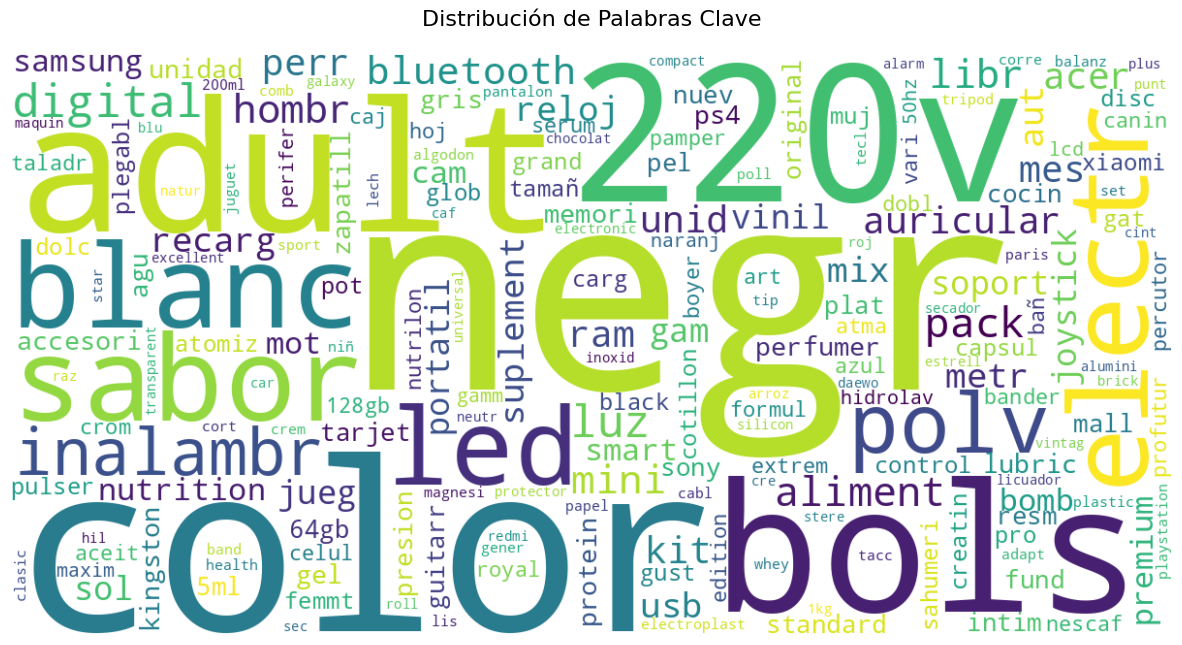

/tmp/ipython-input-4-1813453104.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


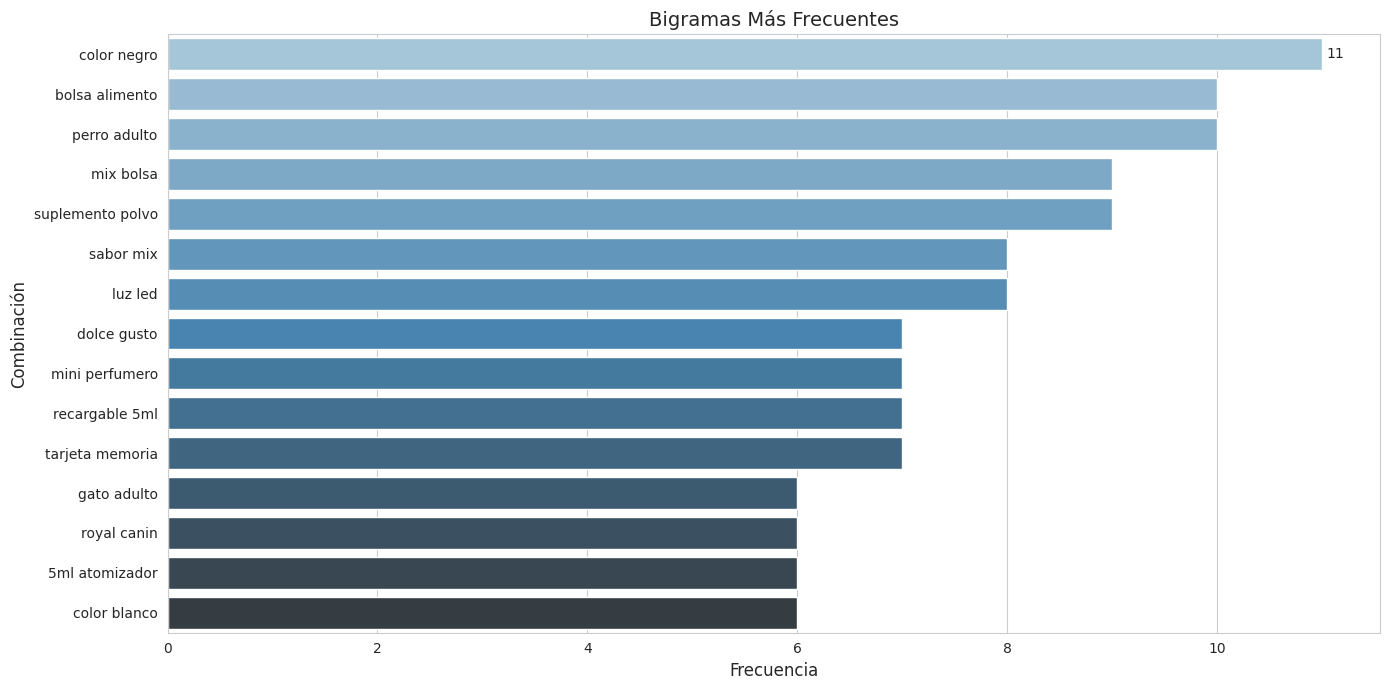


Top 5 Bigramas:
- COLOR NEGRO: 11 apariciones
- BOLSA ALIMENTO: 10 apariciones
- PERRO ADULTO: 10 apariciones
- MIX BOLSA: 9 apariciones
- SUPLEMENTO POLVO: 9 apariciones

Entrenando Word2Vec

Resultados Word2Vec:
- Dimensión de embeddings: (531, 150)
- Palabras en vocabulario: 357

Ejemplo de similitud semántica:
Similar a 'smart': [('plat', 0.9477563500404358), ('color', 0.9474626779556274), ('digital', 0.9462894797325134)]


In [4]:
# Configuración del WordCloud
print("\nGenerando WordCloud")
all_tokens = sum(df['tokens'].tolist(), [])

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    collocations=False,  # Evita bigramas repetidos
    max_words=200,       # Control de cantidad de términos
    colormap='viridis',  # Paleta profesional
    contour_width=1      # Borde delimitador
).generate(' '.join(all_tokens))

# Visualización
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')  # Suavizado
plt.axis("off")
plt.title("Distribución de Palabras Clave", pad=20, fontsize=16)
plt.show()

# Filtrado
df['tokens_sin_stem'] = df['name'].apply(
    lambda x: [
        w for w in word_tokenize(str(x).lower())
        if w.isalnum() and len(w) > 2 and w not in stopwords.words('spanish')  # Filtro mejorado
    ]
)

bigramas = list(bigrams(sum(df['tokens_sin_stem'].tolist(), [])))
freq_bigramas = Counter([' '.join(bg) for bg in bigramas])

# Visualización profesional
top_bigramas = freq_bigramas.most_common(15)
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")  # stilo limpio
ax = sns.barplot(
    x=[freq for _, freq in top_bigramas],
    y=[bg for bg, _ in top_bigramas],
    palette="Blues_d"  # Gradiente de color
)

# Elementos de gráfico
plt.title("Bigramas Más Frecuentes", fontsize=14)
plt.xlabel("Frecuencia", fontsize=12)
plt.ylabel("Combinación", fontsize=12)
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)  # Valores sobre barras
plt.tight_layout()
plt.show()

# Exportación de resultados
print("\nTop 5 Bigramas:")
for bg, freq in top_bigramas[:5]:
    print(f"- {bg.upper()}: {freq} apariciones")

# Configuración
print("\nEntrenando Word2Vec")
model_w2v = Word2Vec(
    sentences=df['tokens'],
    vector_size=150,
    window=7,
    min_count=3,
    workers=4,
    epochs=20,
    seed=42  # Reproducibilidad
)

# Función con documentación
def texto_a_vector(tokens):
    """Convierte tokens en vector promedio de sus embeddings"""
    vectors = [model_w2v.wv[word] for word in tokens if word in model_w2v.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model_w2v.vector_size)

X_w2v = np.array([texto_a_vector(tokens) for tokens in df['tokens']])

# Verificación completa
print("\nResultados Word2Vec:")
print(f"- Dimensión de embeddings: {X_w2v.shape}")
print(f"- Palabras en vocabulario: {len(model_w2v.wv)}")

# Ejemplo práctico con manejo de errores
print("\nEjemplo de similitud semántica:")
try:
    print(f"Similar a 'smart': {model_w2v.wv.most_similar('smart', topn=3)}")
except KeyError:
    print("Palabra 'smart' no está en el vocabulario (probando con 'oferta')...")
    try:
        print(f"Similar a 'oferta': {model_w2v.wv.most_similar('oferta', topn=3)}")
    except KeyError:
        print("Palabra de prueba no encontrada - vocabulario muy específico")


## 5. Modelado Predictivo
Construcción, entrenamiento y evaluación del modelo


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.0464 - loss: 7.5870 - val_accuracy: 0.0375 - val_loss: 6.7162
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0401 - loss: 6.4786 - val_accuracy: 0.0250 - val_loss: 5.7967
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0574 - loss: 5.6034 - val_accuracy: 0.0125 - val_loss: 5.0848
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0809 - loss: 4.9284 - val_accuracy: 0.0250 - val_loss: 4.5493
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1428 - loss: 4.4154 - val_accuracy: 0.0250 - val_loss: 4.1598
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1319 - loss: 4.0487 - val_accuracy: 0.0250 - val_loss: 3.8850
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1505 - loss: 3.7768 - val_accuracy: 0.0375 - val_loss: 3.6989
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1306 - loss: 3.5885 - val_accuracy: 0.0500 - val_loss: 3.5741
Epoch 9/30


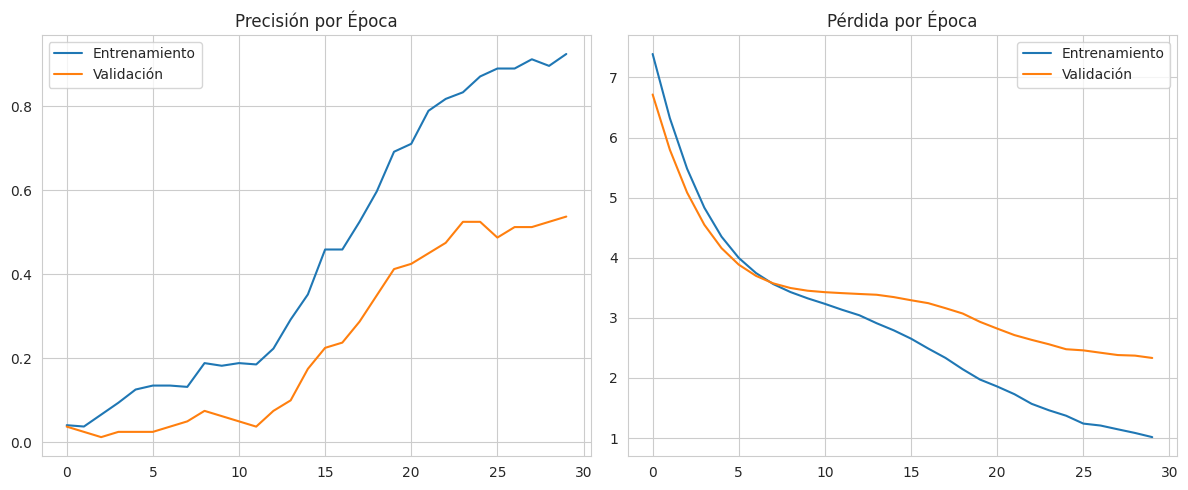

In [5]:
# Preparación De Datos
# Vectorización TF-IDF con bigramas
vectorizer = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2),  # Captura bigramas
    stop_words=stopwords.words('spanish')
)
X_tfidf = vectorizer.fit_transform(df['name']).toarray()

# Codificación de categorías
encoder = LabelEncoder()
y = encoder.fit_transform(df['category_name'])

# División estratificada, conserva proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Arquitectura Del Modelo
model = Sequential([
    Dense(256, activation='relu',
          input_shape=(X_train.shape[1],),
          kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])

# Compilación
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento con Early Stopping
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,  # Tamaño de batch optimizado
    validation_split=0.2,  # Validación durante entrenamiento
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],  # Detención temprana
    verbose=1
)

# Evalución completa
# 1. Métricas de clasificación
y_pred = model.predict(X_test).argmax(axis=1)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# 2. Gráficos de evolución
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por Época')
plt.legend()
plt.tight_layout()
plt.show()


## 6. Análisis Adicionales
Insights complementarios sobre los datos


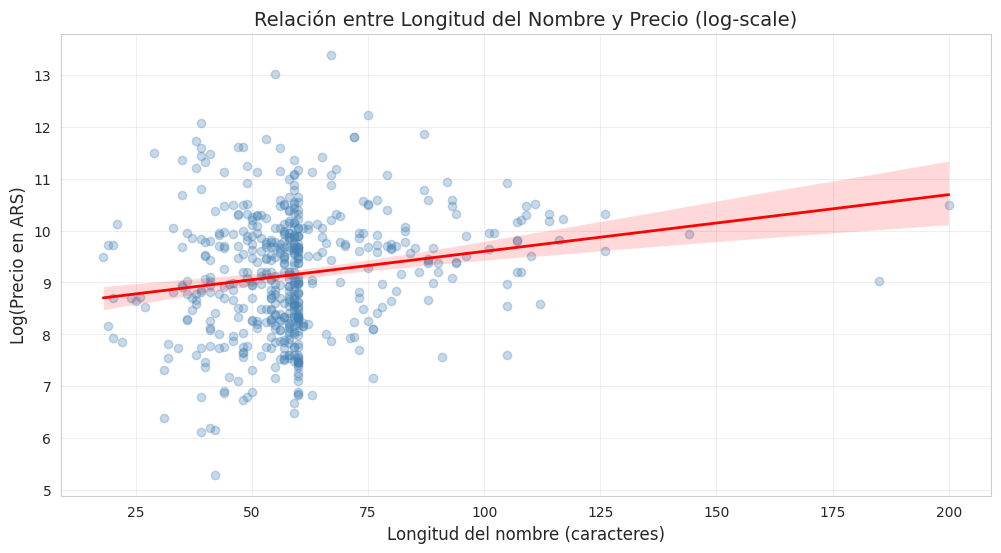


Palabras exclusivas por categoría (TOP 5):

 SOUVENIRS, COTILLÓN Y FIESTAS:
   banderin
   burbujer
   cienfueg
   confetti
   cotillon

 CONSOLAS Y VIDEOJUEGOS:
   neighborvill
   playstation
   dualshock
   microsoft
   minecraft

 JOYAS Y RELOJES:
   policarbonat
   smartwatch
   autoajust
   18444793
   piercing


/tmp/ipython-input-6-1974827310.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


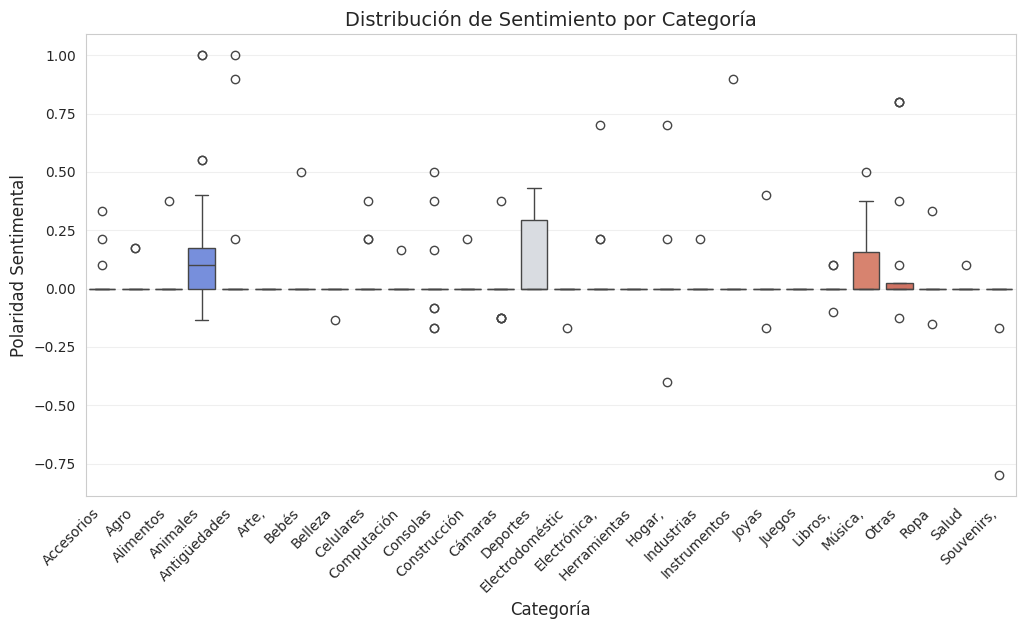

In [6]:
# Relación Longitud-Precio
plt.figure(figsize=(12,6))
sns.regplot(
    x=df['longitud_nombre'],
    y=np.log1p(df['price']),  # Log-transform para mejor visualización
    scatter_kws={'alpha':0.3, 'color':'steelblue'},
    line_kws={'color':'red', 'linewidth':2}
)
plt.title("Relación entre Longitud del Nombre y Precio (log-scale)", fontsize=14)
plt.xlabel("Longitud del nombre (caracteres)", fontsize=12)
plt.ylabel("Log(Precio en ARS)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Palabras Exclusivas Por Categoría
def palabras_exclusivas(df, col_categoria='category_name', top_n=5):
    categorias = df[col_categoria].value_counts().index[:3]
    resultados = {}

    for cat in categorias:
        tokens_cat = set(sum(df[df[col_categoria] == cat]['tokens'].tolist(), []))
        otras_cats = set(sum(df[df[col_categoria] != cat]['tokens'].tolist(), []))
        exclusivas = tokens_cat - otras_cats
        resultados[cat] = sorted(exclusivas, key=lambda x: (-len(x), x))[:top_n]  # Ordena por longitud y alfabéticamente

    return resultados

print("\nPalabras exclusivas por categoría (TOP 5):")
for cat, words in palabras_exclusivas(df).items():
    print(f"\n {cat.upper()}:")
    print("   " + "\n   ".join(words))

# Análisis De Sentimiento
df['sentimiento'] = df['name'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

plt.figure(figsize=(12,6))
sns.boxplot(
    x=df['category_name'].apply(lambda x: x.split()[0][:15]),  # Acorta nombres largos
    y=df['sentimiento'],
    palette='coolwarm'
)
plt.title("Distribución de Sentimiento por Categoría", fontsize=14)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Polaridad Sentimental", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

## 7. Conclusiones Analíticas
Hallazgos clave y recomendaciones estratégicas


Principales Resultados

1. Efecto De Proprocesamiento:
   - Vocabulario reducido a 1682 términos únicos
   - Ejemplo de tokenización: ['smart', 'tech']...

2. Patrones comerciales:
   - Bigramas más frecuentes:
     * Color Negro: 11 repeticiones
     * Bolsa Alimento: 10 repeticiones
     * Perro Adulto: 10 repeticiones
   - Categoría más positiva: 'Animales y Mascotas'

3. Rendimiento del modelo:
   - Precisión final: 53.75%
   - Pérdida mínima: 2.3329


/tmp/ipython-input-7-3908462023.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


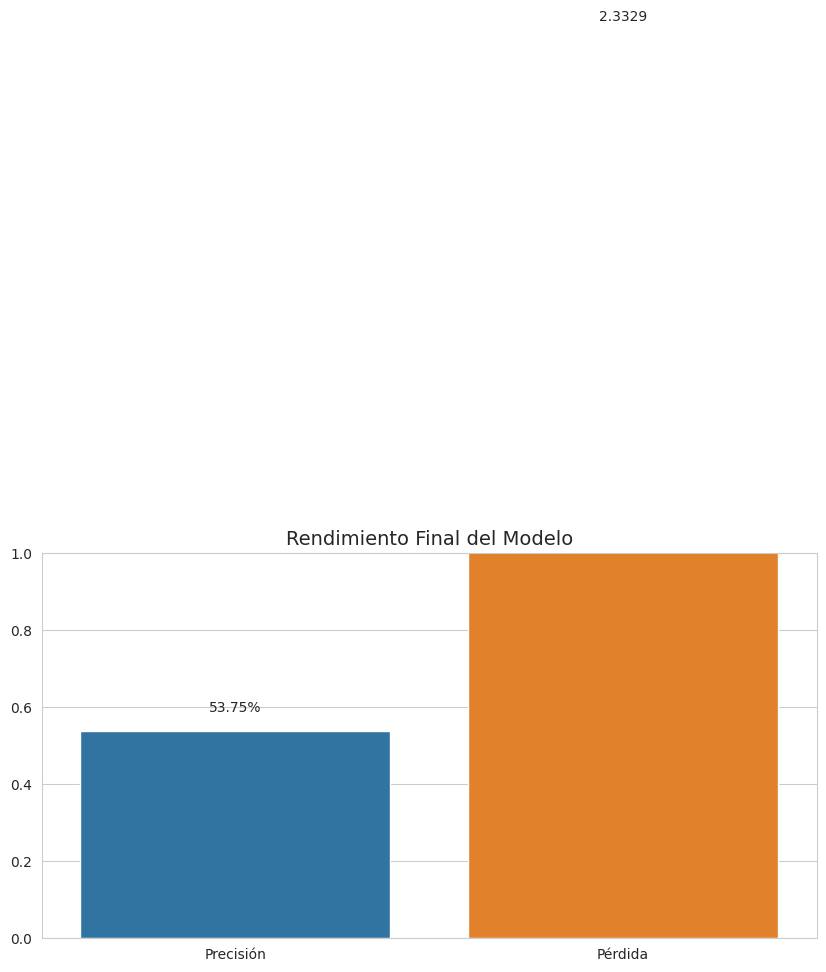

\Recomendaciones Estrátegicas

Para Marketing:
   - Usar bigramas identificados en títulos (ej: 'Kit Led')
   - Potenciar categorías con sentimiento positivo

Para Modelado:
   - Implementar embeddings avanzados (BERT en español)
   - Balancear dataset con técnicas SMOTE

Análisis Futuros:
   - Cruce entre sentimiento y volumen de ventas
   - Segmentación por ubicación geográfica


In [7]:
# Hallazgos Principales
print("\nPrincipales Resultados")

# 1. Efectividad de preprocesamiento
unique_words = len(set(sum(df['tokens'].tolist(), [])))
print(f"\n1. Efecto De Proprocesamiento:")
print(f"   - Vocabulario reducido a {unique_words} términos únicos")
print(f"   - Ejemplo de tokenización: {df['tokens'].iloc[0][:5]}...")  # Muestra primeros 5 tokens

# 2. Patrones comerciales
print("\n2. Patrones comerciales:")
print("   - Bigramas más frecuentes:")
for bg, freq in freq_bigramas.most_common(3):
    print(f"     * {bg.title()}: {freq} repeticiones")

top_cat_sentimiento = df.groupby('category_name')['sentimiento'].mean().idxmax()
print(f"   - Categoría más positiva: '{top_cat_sentimiento}'")

# 3. Rendimiento del modelo
print("\n3. Rendimiento del modelo:")
print(f"   - Precisión final: {history.history['val_accuracy'][-1]:.2%}")
print(f"   - Pérdida mínima: {min(history.history['val_loss']):.4f}")

# Graáfico Comparativo
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
ax = sns.barplot(
    x=['Precisión', 'Pérdida'],
    y=[
        history.history['val_accuracy'][-1],
        min(history.history['val_loss'])
    ],
    palette=['#1f77b4', '#ff7f0e']
)

plt.title('Rendimiento Final del Modelo', fontsize=14)
plt.ylim(0, 1)
for i, v in enumerate([history.history['val_accuracy'][-1], min(history.history['val_loss'])]):
    ax.text(i, v + 0.05, f"{v:.2%}" if i == 0 else f"{v:.4f}", ha='center')
plt.show()

# Recomendaciones
print("\Recomendaciones Estrátegicas")
print("\nPara Marketing:")
print("   - Usar bigramas identificados en títulos (ej: 'Kit Led')")
print("   - Potenciar categorías con sentimiento positivo")

print("\nPara Modelado:")
print("   - Implementar embeddings avanzados (BERT en español)")
print("   - Balancear dataset con técnicas SMOTE")

print("\nAnálisis Futuros:")
print("   - Cruce entre sentimiento y volumen de ventas")
print("   - Segmentación por ubicación geográfica")